# Medical-MNIST CNN

Example of classifying medical mnsit images with TensorFlow

Download the data from https://www.kaggle.com/andrewmvd/medical-mnist. First, click "Download (80 MB)". Sign in with a prefered email and download the zip file. Then uncompress it to `kaggle-medical-mnist/archive` in the project data folder.

Some of the commented code is to allow change to different classes (or add them all to the model).

code from https://www.kaggle.com/sarimsikander/medical-mnist-cnn-99-96-accuracy

In [1]:
import os
import numpy as np
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm  
import cv2
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

%matplotlib inline

In [8]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.path.abspath('')))
DATA_FOLDER = os.path.join(
    ROOT_DIR,
    'data',
    'kaggle-medical-mnist',
    'archive'
)

In [9]:
#classes = {'AbdomenCT': 0, 'BreastMRI': 1, 'ChestCT': 2, 'CXR': 3, 'Hand': 4, 'HeadCT': 5}
classes = {'AbdomenCT': 0, 'ChestCT': 1}

In [10]:
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
BATCH_SIZE = 64
N_CLASSES = 2  # 6 # Change this according to the number of classes, which can be up to 6 in this example (6 types of images available)
EPOCHS = 1 # 5 5 was set when all the classes where used

In [11]:
abdomen_DIR = os.path.join(DATA_FOLDER, 'AbdomenCT') 
#breastmri_DIR = os.path.join(DATA_FOLDER, 'BreastMRI''
chestct_DIR = os.path.join(DATA_FOLDER, 'ChestCT')
#cxr_DIR = os.path.join(DATA_FOLDER, 'CXR')
#hand_DIR = os.path.join(DATA_FOLDER, 'Hand')
#headct = os.path.join(DATA_FOLDER,DATA_FOLDER 'HeadCT')

In [12]:
def assign_label(img,class_type):
    return class_type

X = []
y = []

def make_train_data(class_type,DIR):
    #print(DIR)
    for img in tqdm(os.listdir(DIR)):
        label=assign_label(img,class_type)
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMAGE_WIDTH,IMAGE_HEIGHT))
        
        X.append(np.array(img))
        y.append(str(label))

In [13]:
make_train_data(classes.get('AbdomenCT'), abdomen_DIR)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 219.33it/s]


In [14]:
#make_train_data(classes.get('BreastMRI'), breastmri_DIR)

In [15]:
make_train_data(classes.get('ChestCT'), chestct_DIR)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:46<00:00, 213.67it/s]


In [16]:
#make_train_data(classes.get('CXR'), cxr_DIR)

In [17]:
#make_train_data(classes.get('Hand'), hand_DIR)

In [18]:
#make_train_data(classes.get('HeadCT'), headct)

In [19]:
len(X)
y = np.array(y)
X = np.array(X)
X.shape

(20000, 64, 64, 3)

In [20]:
X_train,X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=58954)

In [21]:
k = len(set(y_train))
print("Number of classes, ", k)

Number of classes,  2


In [22]:
X_train = X_train.astype('float64')/255
X_test = X_test.astype('float64')/255

In [23]:
y_train = to_categorical(y_train, num_classes=k)
y_test = to_categorical(y_test, num_classes=k)

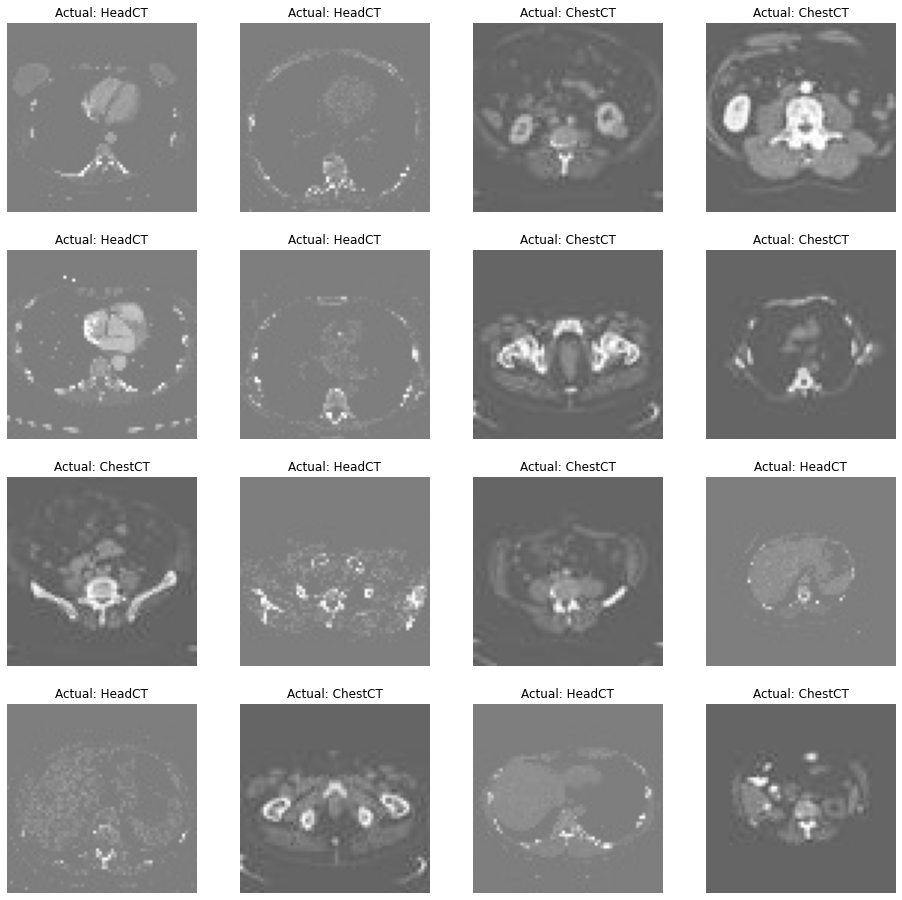

In [24]:
labels = '''ChestCT
HeadCT'''.split("\n")

#labels = '''AbdomenCT
#BreastMRI
#ChestCT
#CXR
#Hand
#HeadCT'''.split("\n")


plt.figure(figsize=(16,16))
j = 1
for i in np.random.randint(0,1000,16):
    plt.subplot(4,4,j); j+=1
    plt.imshow(X_train[i],cmap = 'Greys')
    plt.axis('off')
    plt.title("Actual: {}".format(labels[np.argmax(y_train[i])]))
    #plt.title('{} / {}'.format(labels[y_train[i]],y_train[i]))


In [25]:
i = layers.Input(shape = (X_train[0].shape))
x = layers.Conv2D(64, (3,3), activation='relu', strides = (2,2), padding= 'same')(i)
x = layers.Conv2D(64, (3,3), activation='relu', strides = (2,2), padding= 'same')(x)
x = layers.Conv2D(32, (3,3), activation='relu', strides = (2,2), padding= 'same')(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(k, activation='softmax')(x)

model = Model(i, x)

In [26]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          18464     
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0     

In [27]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', metrics=['accuracy'])

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.1,
                              patience=3, min_lr=0.00001)

model.fit(X_train, y_train, epochs = EPOCHS, batch_size = BATCH_SIZE, 
          validation_data=  (X_test,y_test), callbacks=[reduce_lr])

282/282 [==============================] - 24s 82ms/step - loss: 0.1053 - accuracy: 0.9475 - val_loss: 4.4146e-04 - val_accuracy: 1.0000 - lr: 0.0010


In [28]:
reduce_lr

The class of this is: 1


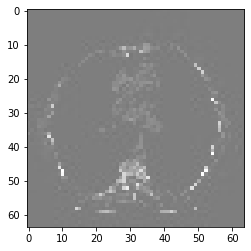

In [29]:
print("The class of this is: {}".format(np.argmax(y_train[10])))
plt.imshow(X_train[10], cmap='gray')
plt.show()

Confusion matrix, without normalization
[[ 992    0]
 [   0 1008]]


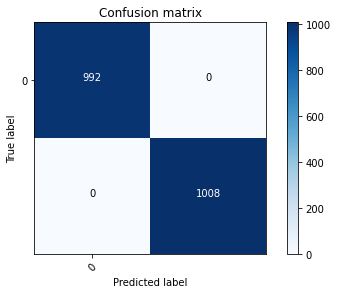

In [30]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


p_test = model.predict(X_test).argmax(axis=1)
cm = confusion_matrix(np.argmax(y_test, axis= 1), p_test)
plot_confusion_matrix(cm, list(range(k-1)))

In [31]:
misclassified_idx = np.where(p_test != np.argmax(y_test, axis= 1))[0]
i = np.random.choice(misclassified_idx)
plt.imshow(X_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (labels[np.argmax(y_test[i])], labels[p_test[i]]));

ValueError: 'a' cannot be empty unless no samples are taken